In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [3]:
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df_train.columns = [col.lower().replace(' ','_') for col in df_train.columns]
df_test.columns = [col.lower().replace(' ','_') for col in df_test.columns]

In [5]:
#  Have to use categorical features as well

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [6]:
df_train.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_yr_blt      114
garage_cond        114
garage_qual        114
garage_finish      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmt_cond           55
bsmt_qual           55
bsmtfin_type_1      55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
garage_cars          1
garage_area          1
bsmtfin_sf_1         1
dtype: int64

In [7]:
df_test.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)

pool_qc           874
misc_feature      837
alley             820
fence             706
fireplace_qu      422
lot_frontage      160
garage_yr_blt      45
garage_finish      45
garage_qual        45
garage_cond        45
garage_type        44
bsmt_exposure      25
bsmtfin_type_1     25
bsmtfin_type_2     25
bsmt_cond          25
bsmt_qual          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
dtype: int64

In [8]:
print(df_train['pool_area'].value_counts())
print(df_train['pool_qc'].value_counts())
print(df_test['pool_area'].value_counts())
print(df_test['pool_qc'].value_counts())

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: pool_area, dtype: int64
Gd    4
Fa    2
TA    2
Ex    1
Name: pool_qc, dtype: int64
0      874
144      1
555      1
512      1
444      1
Name: pool_area, dtype: int64
Ex    3
TA    1
Name: pool_qc, dtype: int64


In [9]:
#  Pool nulls not a problem - null if no pool

In [10]:
#misc_feature      1986
#alley             1911
#fence             1651
#fireplace_qu      1000
#garage_yr_blt      114
#garage_cond        114
#garage_qual        114
#garage_finish      114
#garage_type        113
#bsmt_exposure       58
#bsmtfin_type_2      56
#bsmt_cond           55
#bsmt_qual           55
#bsmtfin_type_1      55
#mas_vnr_area        22
#mas_vnr_type        22
#bsmt_half_bath       2
#bsmt_full_bath       2
#total_bsmt_sf        1
#bsmt_unf_sf          1
#bsmtfin_sf_2         1
#garage_cars          1
#garage_area          1
#bsmtfin_sf_1         1

In [11]:
# frontage - interpolate based on size and type of lot

C:\Users\Ari\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lot_frontage', ylabel='lot_area'>

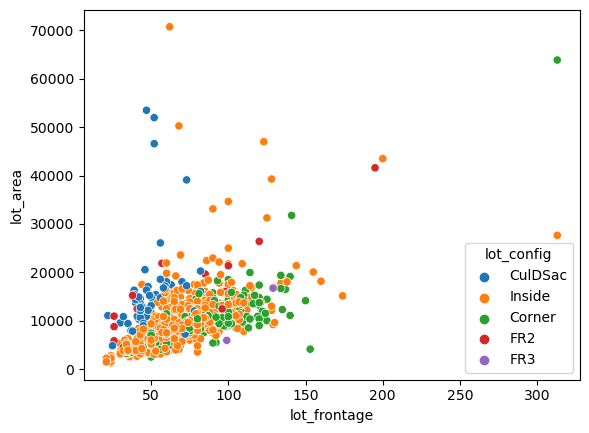

In [12]:
sns.scatterplot(df_train['lot_frontage'],df_train['lot_area'],hue=df_train['lot_config'])

In [13]:
#for df in [df_train,df_test]:
 #   df['lot_config'] = [0 if val == 'FR3'
  #                     else 1 if val == 'FR2'
   #                    else 2 if val == 'Corner'
    #                    else 3 if val == 'Inside'
     #                   else 4
      #                 for val in df['lot_config']]

In [14]:
#X = df_train.loc[df_train['lot_frontage'] > 0, ['lot_area','lot_config']]
#y = df_train.loc[df_train['lot_frontage'] > 0, 'lot_frontage']
#X_val = df_train.loc[df_train['lot_frontage'] == 0, ['lot_area','lot_config']]
#y_val = df_train.loc[df_train['lot_frontage'] == 0, 'lot_frontage']

#X,y,X_val,y_val = train_test_split(X,y,random_state=42)

In [15]:
#lr = LinearRegression()
#lr.fit(X,y)

In [16]:
#  https://www.storycountyiowa.gov/DocumentCenter/View/6074/A-Guide-to-Geo-Numbering-in-Story-County?bidId=

In [17]:
for df in [df_train,df_test]:
    df['pid_1'] = df['pid'].astype('str').str[:1]
    df['pid_2'] = df['pid'].astype('str').str[1:3]
    df['pid_3'] = df['pid'].astype('str').str[3:6]
    df['pid_4'] = df['pid'].astype('str').str[6:9]


In [18]:
df_train.select_dtypes('object').columns

Index(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature',
       'sale_type', 'pid_1', 'pid_2', 'pid_3', 'pid_4'],
      dtype='object')

In [19]:
print(df_train.ms_zoning.value_counts())
print(df_test.ms_zoning.value_counts())

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64
RL         674
RM         146
FV          38
RH          13
C (all)      6
I (all)      1
Name: ms_zoning, dtype: int64


In [20]:
for df in [df_train,df_test]:
    df['ms_zoning'] = [0 if val == 'I (all)' 
                         else 1 if val == 'C (all)' 
                         else 2 if val == 'RH'
                         else 3 if val == 'RM'
                         else 4 if val == 'RL'
                         else 5 if val == 'FV'
                         else 6
                         for val in df['ms_zoning']]

In [21]:
df_train['street'].value_counts()

Pave    2044
Grvl       7
Name: street, dtype: int64

In [22]:
for df in [df_train,df_test]:
    df['street'] = [0 if val == 'Grvl' else 1 for val in df['street']]

In [23]:
df_train['alley'].value_counts()

Grvl    85
Pave    55
Name: alley, dtype: int64

In [24]:
for df in [df_train,df_test]:
    df['alley'] = [0 if val == 'Grvl' else 1 for val in df['alley']]

In [25]:
df_train['lot_shape'].value_counts()

Reg    1295
IR1     692
IR2      55
IR3       9
Name: lot_shape, dtype: int64

In [26]:
for df in [df_train,df_test]:
    df['lot_shape'] = [0 if val == 'IR3' 
                         else 1 if val == 'IR2' 
                         else 2 if val == 'IR1'
                         else 3
                         for val in df['lot_shape']]

In [27]:
df_train['land_contour'].value_counts()

Lvl    1843
HLS      85
Bnk      80
Low      43
Name: land_contour, dtype: int64

In [28]:
for df in [df_train,df_test]:
    df['land_contour'] = [0 if val == 'IR3' 
                         else 1 if val == 'IR2' 
                         else 2 if val == 'IR1'
                         else 3
                         for val in df['land_contour']]

In [29]:
df_train['utilities'].value_counts()

AllPub    2049
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

In [30]:
for df in [df_train,df_test]:
    df['utilities'] = [0 if val == 'NoSeWa'
                       else 1 if val == 'NoSeWr'
                       else 2 
                       for val in df['utilities']]

In [31]:
df_train['lot_config'].value_counts()

Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: lot_config, dtype: int64

In [32]:
for df in [df_train,df_test]:
    df['lot_config'] = [0 if val == 'FR3'
                       else 1 if val == 'FR2'
                       else 2 if val == 'Corner'
                        else 3 if val == 'Inside'
                        else 4
                       for val in df['lot_config']]

In [33]:
df_train['land_slope'].value_counts()

Gtl    1953
Mod      88
Sev      10
Name: land_slope, dtype: int64

In [34]:
for df in [df_train,df_test]:
    df['land_slope'] = [0 if val == 'Sev'
                       else 1 if val == 'Mod'
                       else 2
                       for val in df['land_slope']]

In [35]:
df_train['condition_1'].value_counts()

Norm      1767
Feedr      109
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64

In [36]:
for df in [df_train,df_test]:
    for cond in ['condition_1','condition_2']:
        df[cond] = [0 if (val == 'RRAe') | (val == 'RRAn')
                    else 1 if (val == 'RRNe') | (val == 'RRNn')
                    else 2 if val == 'Artery'
                    else 3 if val == 'Feedr'
                    else 4 if val == 'Normal'
                    else 5 if val == 'PosN'
                    else 6 
                    for val in df[cond]]

In [37]:
df_train['bldg_type'].value_counts()

1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64

In [38]:
for df in [df_train,df_test]:
    df['bldg_type'] = [0 if val == 'Twnhs'
                       else 1 if val == 'TwnhsE'
                       else 2 if val == 'Duplex'
                       else 3 if val == '2fmCon'
                       else 4
                       for val in df['bldg_type']]

In [39]:
df_train['house_style'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

In [40]:
for df in [df_train,df_test]:
    df['house_style'] = [0 if val == '1Story'
                         else 1 if val == '1.5Unf'
                         else 2 if val == '1.5Fin'
                         else 3 if val == 'SLvl'
                         else 4 if val == 'SFoyer'
                         else 5 if val == '2Story'
                         else 6 if val == '2.5Unf'
                         else 7
                       for val in df['house_style']]

In [41]:
for col in ['exter_qual','exter_cond','bsmt_qual','bsmt_cond','heating_qc','kitchen_qual','fireplace_qu','garage_qual','garage_cond','pool_qc']:
    print(df[col].value_counts())

TA    552
Gd    292
Ex     25
Fa      9
Name: exter_qual, dtype: int64
TA    770
Gd     84
Fa     18
Ex      5
Po      1
Name: exter_cond, dtype: int64
TA    396
Gd    355
Ex     73
Fa     28
Po      1
Name: bsmt_qual, dtype: int64
TA    781
Fa     39
Gd     33
Name: bsmt_cond, dtype: int64
Ex    429
TA    267
Gd    157
Fa     25
Name: heating_qc, dtype: int64
TA    447
Gd    354
Ex     53
Fa     23
Po      1
Name: kitchen_qual, dtype: int64
Gd    220
TA    193
Fa     16
Po     15
Ex     12
Name: fireplace_qu, dtype: int64
TA    782
Fa     42
Gd      6
Po      3
Name: garage_qual, dtype: int64
TA    796
Fa     27
Po      6
Gd      3
Ex      1
Name: garage_cond, dtype: int64
Ex    3
TA    1
Name: pool_qc, dtype: int64


In [42]:
for df in [df_train,df_test]:
    for col in ['exter_qual','exter_cond','bsmt_qual','bsmt_cond',
                'heating_qc','kitchen_qual','fireplace_qu','garage_qual','garage_cond','pool_qc']:
        df[col] = [0 if val == 'NA'
                   else 1 if val == 'Po'
                   else 2 if val == 'Fa'
                   else 3 if val == 'TA'
                   else 4 if val == 'Gd'
                   else 5
                   for val in df[col]]
                

In [43]:
df_train['bsmt_exposure'].value_counts()

No    1339
Av     288
Gd     203
Mn     163
Name: bsmt_exposure, dtype: int64

In [44]:
for df in [df_train,df_test]:
    df['bsmt_exposure'] = [0 if val == 'NA'
                           else 1 if val == 'No'
                           else 2 if val == 'Mn'
                           else 3 if val == 'Av'
                           else 4 
                           for val in df['bsmt_exposure']]

In [45]:
print(df_train['bsmtfin_type_1'].value_counts())
print(df_train['bsmtfin_type_2'].value_counts())

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: bsmtfin_type_1, dtype: int64
Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: bsmtfin_type_2, dtype: int64


In [46]:
for df in [df_train,df_test]:
    for col in ['bsmtfin_type_1','bsmtfin_type_2']:
        df[col] = [0 if val == 'NA'
                   else 1 if val == 'Unf'
                   else 2 if val == 'LwQ'
                   else 3 if val == 'Rec'
                   else 4 if val == 'BLQ'
                   else 5 if val == 'ALQ'
                   else 6
                   for val in df[col]]

In [47]:
df_train['garage_type'].value_counts()

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64

In [48]:
for df in [df_train,df_test]:
    df['garage_type'] = [0 if val == 'NA'
                         else 1 if val == 'CarPort'
                         else 2 if val == 'Detchd'
                         else 3 if val == 'Basment'
                         else 4 if val == 'Attchd'
                         else 5 if val == 'BuiltIn'
                         else 6
                         for val in df['garage_type']]

In [49]:
df_train['garage_finish'].value_counts()

Unf    849
RFn    579
Fin    509
Name: garage_finish, dtype: int64

In [50]:
for df in [df_train,df_test]:
    df['garage_finish'] = [0 if val == 'NA'
                           else 1 if val == 'Unf'
                           else 2 if val == 'RFn'
                           else 3
                           for val in df['garage_finish']]

In [51]:
df_train['electrical'].value_counts()

SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

In [52]:
for df in [df_train,df_test]:
    df['electrical'] = [0 if val == 'FuseP'
                        else 1 if val == 'FuseF'
                        else 2 if val == 'FuseA'
                        else 3 if val == 'Mix'
                        else 4
                        for val in df['electrical']]

In [53]:
df_train['central_air'].value_counts()

Y    1910
N     141
Name: central_air, dtype: int64

In [54]:
for df in [df_train,df_test]:
    df['central_air'] = [1 if val == 'Y' else 0 for val in df['central_air']]

In [55]:
df_train['functional'].value_counts()

Typ     1915
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        2
Name: functional, dtype: int64

In [56]:
for df in [df_train,df_test]:
    df['functional'] = [0 if val == 'Sal'
                        else 1 if val == 'Sev'
                        else 2 if val == 'Maj2'
                        else 3 if val == 'Maj1'
                        else 4 if val == 'Mod'
                        else 5 if val == 'Min2'
                        else 6 if val == 'Min1'
                        else 7
                        for val in df['functional']]

In [57]:
df_train['paved_drive'].value_counts()

Y    1861
N     151
P      39
Name: paved_drive, dtype: int64

In [58]:
for df in [df_train,df_test]:
    df['paved_drive'] = [0 if val == 'N'
                         else 1 if val == 'P'
                         else 2
                         for val in df['paved_drive']]

In [59]:
df_train['fence'].value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: fence, dtype: int64

In [60]:
#for df in [df_train,df_test]:
 #   df['fence_mat'] = [0 if val == 'NA'
  #                     else 1 if val == 'MnWw'
   #                    else 2 if val == 'GdWo'
    #                   for val in df['fence']]
  #  df['fence_priv'] = [0 if val == 'NA'
   #                     else 1 if val == 'MnPrv'
    #                    else 2 if val == 'GdPrv'
     #                   for val in df['fence']]

In [61]:
#  One-hot for  roof style, roof matl, exterior 1st/2nd, mas vnr type, foundation, 
# heating,  misc feature, sale type

In [62]:
df_train.shape, df_test.shape

((2051, 85), (878, 84))

In [63]:
set(df_train.columns) - set(df_test.columns)

{'saleprice'}

In [64]:
df_train.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)

misc_feature      1986
fence             1651
lot_frontage       330
garage_yr_blt      114
mas_vnr_type        22
mas_vnr_area        22
bsmt_full_bath       2
bsmt_half_bath       2
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
garage_cars          1
garage_area          1
dtype: int64

In [65]:
df_test.isnull().sum().loc[lambda x: x > 0].sort_values(ascending=False)

misc_feature     837
fence            706
lot_frontage     160
garage_yr_blt     45
mas_vnr_type       1
mas_vnr_area       1
dtype: int64

In [66]:
#  See if nulls are meaningful - can we impute? - null might mean it doesn't exist

In [67]:
for df in [df_train,df_test]:
    df['pid_1'] = pd.to_numeric(df['pid_1'])
    df['pid_2'] = pd.to_numeric(df['pid_2'])
    df['pid_3'] = pd.to_numeric(df['pid_3'])
    df['pid_4'] = pd.to_numeric(df['pid_4'])

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
 
ctx = ColumnTransformer(
    [('ohe', 
      OneHotEncoder(drop='first',
                   sparse=False,
                   handle_unknown='ignore'),
      ['neighborhood','roof_style','roof_matl','exterior_1st','exterior_2nd','heating','sale_type'])
    ],
    remainder='passthrough')
ctx.fit_transform(df_train)
ctx.fit_transform(df_test)

df_train = pd.DataFrame(ctx.fit_transform(df_train), columns = ctx.get_feature_names_out())
df_test = pd.DataFrame(ctx.fit_transform(df_test), columns = ctx.get_feature_names_out())

In [69]:
df_test = df_test[[col for col in df_train.columns if (col in df_test.columns) & (col != 'saleprice')]].copy()

In [70]:
# Convert categoricals before doing this

# df_train = df_train.select_dtypes('number')
# df_test = df_test.select_dtypes('number')

In [71]:
df_train.dropna(axis = 1,inplace=True)

In [72]:
df_train.shape, df_test.shape

((2051, 141), (878, 144))

In [73]:
set(df_train.columns) - set(df_test.columns)

{'ohe__exterior_1st_CBlock',
 'ohe__exterior_1st_ImStucc',
 'ohe__exterior_1st_Stone',
 'ohe__exterior_2nd_Stone',
 'ohe__heating_OthW',
 'ohe__heating_Wall',
 'ohe__neighborhood_GrnHill',
 'ohe__neighborhood_Landmrk',
 'ohe__roof_matl_CompShg',
 'ohe__roof_matl_Membran',
 'remainder__saleprice'}

In [74]:
df_train.drop(columns = ['ohe__exterior_1st_CBlock',
 'ohe__exterior_1st_ImStucc',
 'ohe__exterior_1st_Stone',
 'ohe__exterior_2nd_Stone',
 'ohe__heating_OthW',
 'ohe__heating_Wall',
 'ohe__neighborhood_GrnHill',
 'ohe__neighborhood_Landmrk',
 'ohe__roof_matl_CompShg',
 'ohe__roof_matl_Membran'],axis=1, inplace=True) 

In [75]:
df_train = df_train.apply(pd.to_numeric,errors='coerce')

In [76]:
df_test = df_test.apply(pd.to_numeric,errors='coerce')

In [77]:
df_train.dropna(axis=1,inplace=True)

In [78]:
df_test.dropna(axis=1,inplace=True)

In [79]:
df_train.shape, df_test.shape

((2051, 130), (878, 137))

In [80]:
set(df_test.columns) - set(df_train.columns)

{'remainder__bsmt_full_bath',
 'remainder__bsmt_half_bath',
 'remainder__bsmt_unf_sf',
 'remainder__bsmtfin_sf_1',
 'remainder__bsmtfin_sf_2',
 'remainder__garage_area',
 'remainder__garage_cars',
 'remainder__total_bsmt_sf'}

In [81]:
df_test.drop(columns = ['remainder__bsmt_full_bath',
 'remainder__bsmt_half_bath',
 'remainder__bsmt_unf_sf',
 'remainder__bsmtfin_sf_1',
 'remainder__bsmtfin_sf_2',
 'remainder__garage_area',
 'remainder__garage_cars',
 'remainder__total_bsmt_sf'],inplace=True)

In [82]:
set(df_test.columns) - set(df_train.columns)

set()

In [83]:
df_train.shape, df_test.shape

((2051, 130), (878, 129))

### Preprocessing

In [84]:
df_train.head()

,ohe__neighborhood_Blueste,ohe__neighborhood_BrDale,ohe__neighborhood_BrkSide,ohe__neighborhood_ClearCr,ohe__neighborhood_CollgCr,ohe__neighborhood_Crawfor,ohe__neighborhood_Edwards,ohe__neighborhood_Gilbert,ohe__neighborhood_Greens,ohe__neighborhood_IDOTRR,...,remainder__pool_area,remainder__pool_qc,remainder__misc_val,remainder__mo_sold,remainder__yr_sold,remainder__saleprice,remainder__pid_1,remainder__pid_2,remainder__pid_3,remainder__pid_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,0,3,2010,130500,5,33,352,170
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,0,4,2009,220000,5,31,379,50
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,0,1,2010,109000,5,35,304,180
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,0,4,2010,174000,9,16,386,60
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,5,0,3,2010,138500,9,6,425,45


In [101]:
#  Devin is dropping PID, I want to keep

X = df_train.drop(columns = ['remainder__saleprice'])
y = df_train['remainder__saleprice']

In [102]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 13
)

In [103]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1640, 129), (411, 129), (1640,), (411,))

In [104]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 1405 to 338
Columns: 129 entries, ohe__neighborhood_Blueste to remainder__pid_4
dtypes: float64(67), int64(62)
memory usage: 1.6 MB


In [105]:
x = [(X_train.columns[col], variance_inflation_factor(X_train.values,col)) for col in range(len(X_train.columns))]

C:\Users\Ari\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Ari\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [90]:
sorted(x, key=lambda x: x[1], reverse=True)

[('remainder__pid', inf),
 ('remainder__1st_flr_sf', inf),
 ('remainder__2nd_flr_sf', inf),
 ('remainder__low_qual_fin_sf', inf),
 ('remainder__gr_liv_area', inf),
 ('remainder__pid_1', inf),
 ('remainder__pid_4', 81145939231900.83),
 ('remainder__pid_2', 33114703142430.117),
 ('remainder__pid_3', 1690857753846.629),
 ('remainder__id', 266.21554607323344),
 ('remainder__yr_sold', 255.54942076055943),
 ('ohe__roof_style_Gable', 65.97538014457231),
 ('ohe__roof_style_Hip', 63.03357798222876),
 ('ohe__exterior_2nd_VinylSd', 53.08676586173865),
 ('ohe__exterior_1st_VinylSd', 50.76816320944323),
 ('ohe__exterior_2nd_CmentBd', 43.878158667650155),
 ('ohe__exterior_2nd_MetalSd', 43.1034686693894),
 ('ohe__exterior_1st_CemntBd', 42.86419425636311),
 ('ohe__exterior_1st_MetalSd', 42.63763925507215),
 ('ohe__exterior_1st_HdBoard', 23.666797004951484),
 ('ohe__exterior_2nd_HdBoard', 23.621603727764384),
 ('ohe__exterior_2nd_Wd Sdng', 19.739035171944362),
 ('ohe__exterior_1st_Wd Sdng', 19.65797328

In [106]:
for df in [X_train,X_val,y,y_val]:
    df.drop(columns = ['remainder__pid'],inplace=True)
x = [[X_train.columns[col], variance_inflation_factor(X_train.values,col)] for col in range(len(X_train.columns))]
sorted(x, key=lambda x: x[1], reverse=True)

C:\Users\Ari\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[['remainder__1st_flr_sf', inf],
 ['remainder__2nd_flr_sf', inf],
 ['remainder__low_qual_fin_sf', inf],
 ['remainder__gr_liv_area', inf],
 ['remainder__land_contour', 601655866.6522424],
 ['remainder__id', 266.21554607405176],
 ['remainder__yr_sold', 255.54942084862964],
 ['remainder__pid_1', 151.8047448370827],
 ['remainder__pid_2', 81.44374338575624],
 ['ohe__roof_style_Gable', 65.97538014458682],
 ['ohe__roof_style_Hip', 63.03357798247711],
 ['ohe__exterior_2nd_VinylSd', 53.08676586175367],
 ['ohe__exterior_1st_VinylSd', 50.768163209451245],
 ['ohe__exterior_2nd_CmentBd', 43.878158667789734],
 ['ohe__exterior_2nd_MetalSd', 43.103468669392086],
 ['ohe__exterior_1st_CemntBd', 42.86419425641411],
 ['ohe__exterior_1st_MetalSd', 42.63763925511131],
 ['ohe__exterior_1st_HdBoard', 23.666797004952787],
 ['ohe__exterior_2nd_HdBoard', 23.62160372784145],
 ['ohe__exterior_2nd_Wd Sdng', 19.739035171951024],
 ['ohe__exterior_1st_Wd Sdng', 19.657973289218013],
 ['ohe__neighborhood_NAmes', 19.1737

In [107]:
for df in [X_train,X_val,y,y_val]:
    df.drop(columns = ['remainder__1st_flr_sf','remainder__2nd_flr_sf','remainder__low_qual_fin_sf'],inplace=True)
x = [[X_train.columns[col], variance_inflation_factor(X_train.values,col)] for col in range(len(X_train.columns))]
sorted(x, key=lambda x: x[1], reverse=True)

[['remainder__land_contour', 601320435.9333848],
 ['remainder__id', 266.0787242626621],
 ['remainder__yr_sold', 255.41341829743826],
 ['remainder__pid_1', 151.78419881918936],
 ['remainder__pid_2', 81.40442592241811],
 ['ohe__roof_style_Gable', 65.92213602743976],
 ['ohe__roof_style_Hip', 62.99787289402879],
 ['ohe__exterior_2nd_VinylSd', 52.98633859665164],
 ['ohe__exterior_1st_VinylSd', 50.49375833503161],
 ['ohe__exterior_2nd_CmentBd', 43.716585906620146],
 ['ohe__exterior_2nd_MetalSd', 42.95400121762334],
 ['ohe__exterior_1st_CemntBd', 42.667894888371976],
 ['ohe__exterior_1st_MetalSd', 42.39081349041348],
 ['ohe__exterior_2nd_HdBoard', 23.542063198734663],
 ['ohe__exterior_1st_HdBoard', 23.526703242531568],
 ['ohe__exterior_2nd_Wd Sdng', 19.698980503533765],
 ['ohe__exterior_1st_Wd Sdng', 19.561410876424947],
 ['ohe__neighborhood_NAmes', 19.15925016091022],
 ['ohe__exterior_2nd_Plywood', 15.740628036820505],
 ['ohe__neighborhood_CollgCr', 14.566192170166266],
 ['ohe__neighborhood_

In [108]:
for df in [X_train,X_val,y,y_val]:
    df.drop(columns = ['remainder__id'],inplace=True)
x = [[X_train.columns[col], variance_inflation_factor(X_train.values,col)] for col in range(len(X_train.columns))]
sorted(x, key=lambda x: x[1], reverse=True)

[['remainder__land_contour', 2774378.1306357663],
 ['remainder__pid_1', 80.75575079409946],
 ['ohe__roof_style_Gable', 65.88325125593414],
 ['ohe__roof_style_Hip', 62.95598887328536],
 ['ohe__exterior_2nd_VinylSd', 52.95299672828359],
 ['ohe__exterior_1st_VinylSd', 50.44828904601805],
 ['remainder__pid_2', 49.16234988741973],
 ['ohe__exterior_2nd_CmentBd', 43.59240681497448],
 ['ohe__exterior_2nd_MetalSd', 42.951337189644846],
 ['ohe__exterior_1st_CemntBd', 42.56348097824444],
 ['ohe__exterior_1st_MetalSd', 42.390244045450935],
 ['ohe__exterior_2nd_HdBoard', 23.5416542203916],
 ['ohe__exterior_1st_HdBoard', 23.518241942036855],
 ['ohe__exterior_2nd_Wd Sdng', 19.684745730309636],
 ['ohe__exterior_1st_Wd Sdng', 19.54500197002535],
 ['ohe__neighborhood_NAmes', 19.133290639676016],
 ['ohe__exterior_2nd_Plywood', 15.73824512660643],
 ['ohe__neighborhood_CollgCr', 14.533464162512653],
 ['ohe__neighborhood_OldTown', 13.135381300157709],
 ['ohe__exterior_1st_Plywood', 13.01875485977755],
 ['oh

### Feature Engineering

In [78]:
tr_id = X_train['id']
val_id = X_val['id']

In [109]:
poly = PolynomialFeatures(
    degree = 2,
    interaction_only = True,
    include_bias = False
)

In [110]:
X_train = poly.fit_transform(
    X_train
)

# Reconstruct DataFrame
X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

X_val = poly.fit_transform(
    X_val
)

# Reconstruct DataFrame
X_val = pd.DataFrame(X_val, columns = poly.get_feature_names_out())

In [111]:
#  300 permutations (25*24/2) + original 25 features

X_train.shape,X_val.shape

((1640, 7750), (411, 7750))

In [ ]:
X_train.corr()

### More Pre-Processing

In [112]:
#  Scaling

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())

Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

### Modeling and Evaluation

####  Linear Model

In [82]:
#  Create baseline (null) model and get score
#  (Always predict mean_y)

In [113]:
lr = LinearRegression()

# fit to scaled trained data
lr.fit(Xs_train,y_train)

LinearRegression()

In [114]:
cross_val_score(lr,Xs_train,y_train)

array([0.39417924, 0.38368049, 0.17270332, 0.12623197, 0.26039255])

In [115]:
lr.score(Xs_train,y_train)

1.0

In [116]:
lr.score(Xs_val,y_val)

-1.529123423324775

In [117]:
#  Horribly overfit!!!  Way too many features!!!

In [118]:
#  Rank by RMSE

mean_squared_error(y_train, lr.predict(Xs_train),squared=False)

# Average prediction off by 21k on train

1.4082690676420957e-09

In [119]:
mean_squared_error(y_val, lr.predict(Xs_val),squared=False)

# Average prediction off by quadrillions on validation!!!

125151.03306118428

In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [140]:
corr = pd.DataFrame(data = X_train.corr(), columns = X_train.columns)

In [178]:
values = []
for i in X_train.columns:
    for j in X_train.columns:
        values.append((i,j,X_train[[i,j]].corr().unstack()[1:][0]))
 

TypeError: list indices must be integers or slices, not str

In [91]:
#  Combat overfitting
#  1.  Reduce no of features (check for collinearity/ all 5 model assumptions)
#  2.  Get more data
#  3.  Regularization -- add penalty terms to square errors/loss function
#       --- Ridge and Lasso

#### Lasso 

#### Ridge

In [120]:
ridge = RidgeCV(alphas = np.logspace(0,5,100))
ridge.fit(Xs_train,y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]))

In [121]:
#  what is best alpha?
ridge.alpha_

4328.761281083057

In [122]:
# score it twice
ridge.score(Xs_train,y_train)


0.9424772818663066

In [123]:
ridge.score(Xs_val,y_val)

0.813434003394979

In [124]:
# much less overfit

In [125]:
mean_squared_error(y_train,ridge.predict(Xs_train),squared=False)

19036.462092060494

In [126]:
mean_squared_error(y_val,ridge.predict(Xs_val),squared=False)

33991.13553021051

In [127]:
# convergence warnings - gradient doesn't converge (esp on Lasso)
# put import at top

import warnings 

In [128]:
lasso = LassoCV(alphas = np.logspace(0.05,10,1))

#  with - only in this function
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train,y_train)
    

KeyboardInterrupt: 

In [ ]:
lasso = LassoCV(alphas = 1)
lasso.fit(Xs_train, y_train)

In [ ]:
lasso.score(Xs_train, y_train)

In [ ]:
lasso.score(Xs_val, y_val)

In [ ]:
mean_squared_error(y_train, lasso.predict(Xs_train), squared = False)

In [ ]:
mean_squared_error(y_val, lasso.predict(Xs_val), squared = False)

In [ ]:
lasso.coef_

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [129]:
x = [(X_train.columns[col], variance_inflation_factor(X_train.values,col)) for col in range(len(X_train.columns))]

C:\Users\Ari\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

In [ ]:
sorted(x, key=lambda x: x[1], reverse=True)

In [ ]:
output = []
for i in range(len(X_train.columns)):
    print(f'{X_train.columns[i]}: {variance_inflation_factor(X_train.values,i)}')
    output.append((X_train.columns[i],variance_inflation_factor(X_train.values,i)))

In [ ]:
sorted(output, key=lambda output: output[1], reverse=True)

#### Make Predictions

In [ ]:
# do to val and test everything done to train
#  probably should do this as you go along

In [ ]:
test_id = df_test['id']

In [ ]:
df_test = poly.transform(df_test.drop(columns = ['id']))
Xs_test = pd.DataFrame(
    ss.transform(df_test),
    columns = poly.get_feature_names_out()
)

In [ ]:
# instantiate best model

lasso_sub = Lasso(alpha = lasso.alpha_)
lasso_sub.fit(Xs_train,y_train)
preds = lasso_sub.predict(Xs_test)

In [ ]:
preds = pd.DataFrame({'Id': test_id,'SalePrice': preds})

In [ ]:
preds.to_csv('./submissions/lasso_1_simple.csv', index=False)

In [ ]:
## store scores along the way 

In [ ]:
# Submit to kaggle